In [126]:
import xarray as xr, matplotlib, matplotlib.pyplot as plt, glob, re, pandas as pd, geopandas as gpd, cartopy, numpy as np, regionmask
from dateutil.relativedelta import relativedelta
from datetime import datetime
from IPython.display import clear_output
from functools import reduce

mapproj = cartopy.crs.PlateCarree()
matplotlib.rcParams['savefig.bbox'] = "tight"    # always save with tight bounding box
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec


sf_chile2024 = gpd.read_file("sf_chile2024")
sf_chile2026 = gpd.read_file("sf_chile2026")
sf_patagonia = gpd.read_file("sf_patagonia")

# sf_losalerces = gpd.read_file("sf_losalerces")
# sf_losalerces = sf_losalerces.loc[[n == "Los Alerces" for n in sf_losalerces.nam]]

Xn,Xx,Yn,Yx = [-80,-50,-60,-30]

In [37]:
def wrap_lon(ds):
    
    # method to 'wrap' longitudes from (0,360) to (-180,180) & sort into ascending order
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds


def decode_times(ts):
    
    # Method to manually decode times
    inc = re.sub(" .+", "", ts.time.units)
    startdate = pd.Timestamp(re.sub(".+since ", "", ts.time.units)+' 00:00:00.000000').to_pydatetime()
    
    if inc == "years":
        new_times = [np.datetime64(startdate + relativedelta(years = i)) for i in ts.time.values]
    elif inc == "months":
        new_times = [np.datetime64(startdate + relativedelta(months = i)) for i in ts.time.values]
    elif inc == "days":
        new_times = [np.datetime64(startdate + relativedelta(days = i)) for i in ts.time.values]
    elif inc == "hours":
        new_times = [np.datetime64(startdate + relativedelta(hours = i)) for i in ts.time.values]
    else:
        print("TBD: " +inc)
        return
        
    ts = ts.assign_coords(time = new_times)
    
    return ts


def merge_byindex(df_list): 
    
    # merge a list of dataframes by matching indices
    return reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'outer'), df_list)


class MidpointNormalise(matplotlib.colors.Normalize):
    """ From: https://matplotlib.org/users/colormapnorms.html"""
    def __init__(self, vmin=None, vmax=None, midpoint=0, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...

        result, is_scalar = self.process_value(value)
        self.autoscale_None(result)

        vlargest = max( abs( self.vmax - self.midpoint ), abs( self.vmin - self.midpoint ) )
        x, y = [ self.midpoint - vlargest, self.midpoint, self.midpoint + vlargest], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Burned area

In [ ]:
px = pd.read_csv("data/modis_conf-80.csv", index_col = "acq_date", parse_dates = ["acq_date"])
px = gpd.GeoDataFrame(px, geometry = gpd.points_from_xy(x=px.longitude, y=px.latitude), crs = "EPSG:4326").sort_index()

In [19]:
px_2024 = px.loc[slice("2024-01", "2024-02")]
px_2026 = px.loc["2026-01"]

In [22]:
# px_2026.to_csv("fire-blobs.csv") # for Tom to include in the map

/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


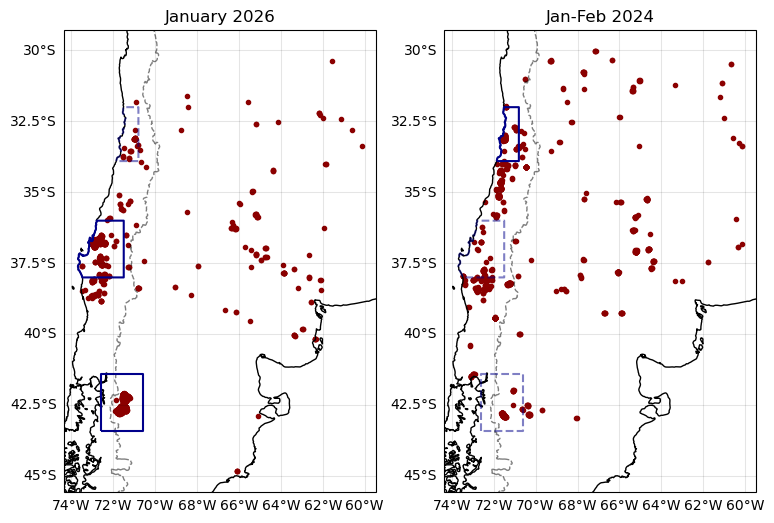

In [9]:
nc = 2
fig, axs = plt.subplots(ncols = nc, figsize = (nc*4.5, 6), dpi = 100, subplot_kw = {"projection" : mapproj}, sharex = True, sharey = True)#, "extent": [xn,xx,yn,yx]})

ax = axs[1]
px_2024.plot(ax = ax, color = "darkred", marker = ".")
sf_chile2024.boundary.plot(ax = ax, color = "darkblue", alpha = 1)
sf_chile2026.boundary.plot(ax = ax, color = "darkblue", alpha = 0.5, ls = "--")
sf_patagonia.boundary.plot(ax = ax, color = "darkblue", alpha = 0.5, ls = "--")
ax.set_title("Jan-Feb 2024")

ax = axs[0]
px_2026.plot(ax = ax, color = "darkred", marker = ".")
sf_chile2024.boundary.plot(ax = ax, color = "darkblue", alpha = 0.5, ls = "--")
sf_chile2026.boundary.plot(ax = ax, color = "darkblue", alpha = 1)
sf_patagonia.boundary.plot(ax = ax, color = "darkblue", alpha = 1)
# sf_losalerces.boundary.plot(ax = ax, color = "orange", alpha = 1)

ax.set_title("January 2026")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["left", "bottom"])

plt.savefig("fig/expl_modis_initial-regions.png")

## Timing of fires

In [1]:
rnm = "chile2026"

sf = eval("sf_"+rnm)
xn,yn,xx,yx = sf.bounds.values[0]
b = 1

px = px_2026.clip((xn-b,yn-b,xx+b,yx+b)).sort_index()

NameError: name 'sf_chile2026' is not defined

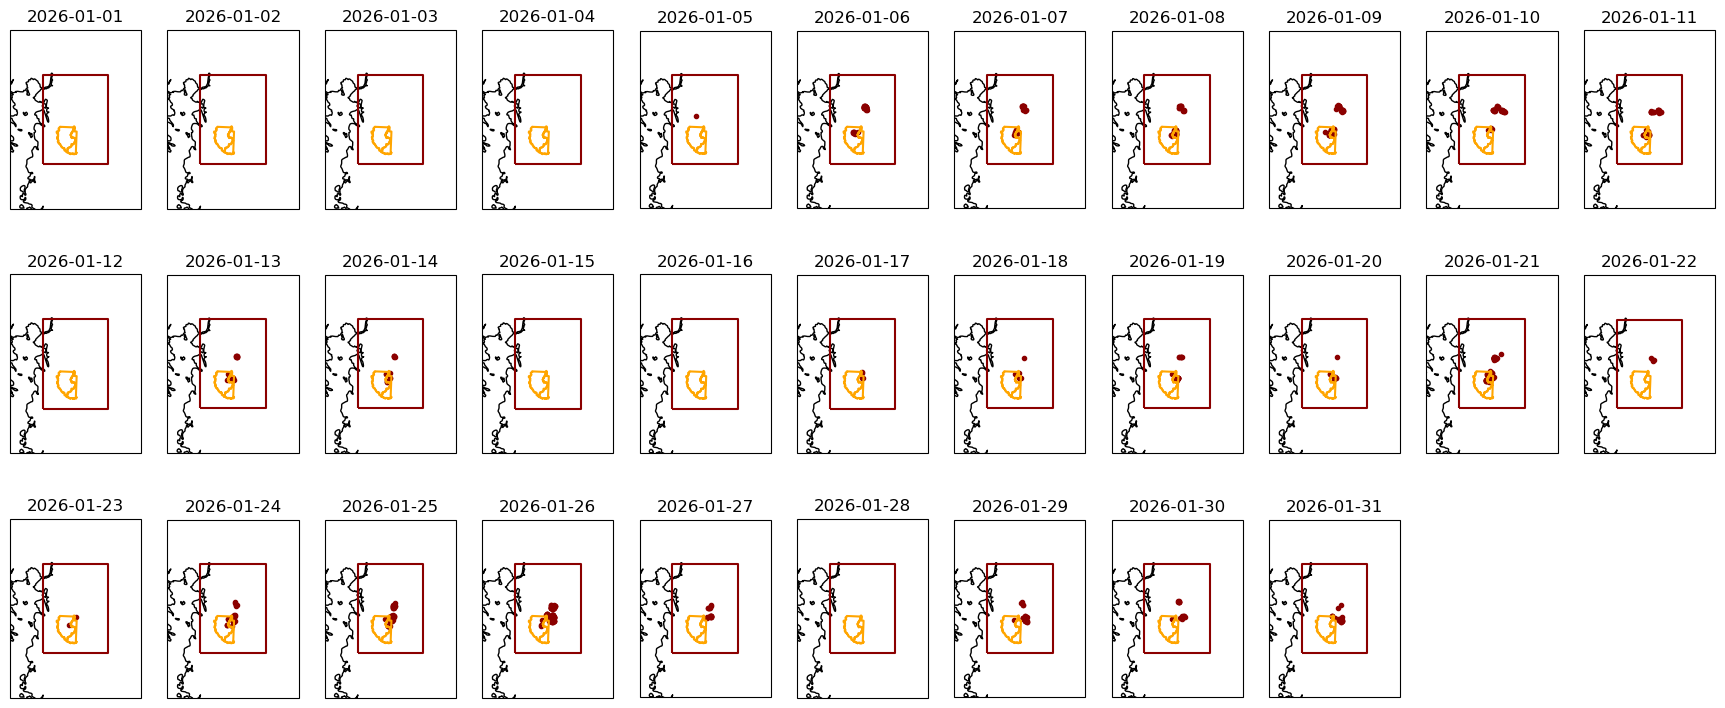

In [27]:
nc = 11; nr = int(np.ceil(31/nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*2, nr*3), dpi = 100, subplot_kw = {"projection" : mapproj, "extent" : (xn-b,xx+b,yn-b,yx+b)}, sharex = True, sharey = True)

for i in range(31):
    ax = axs.flatten()[i]
    d = datetime(2026,1,i+1).strftime("%Y-%m-%d")

    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkred", alpha = 1)

    ax.set_title(d)
    
    if not d in px.index: continue
    px_d = px.loc[[d]]
    px_d.plot(ax = ax, marker = ".", color = "darkred")

for i in range(31,nc*nr): axs.flatten()[i].set_axis_off()

plt.savefig("fig/expl_modis-daily_"+rnm+".png")

# Physical geography

In [8]:
elev = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/elev.0.25-deg.nc", decode_times = False).squeeze(drop = True).data).sel(lon = slice(Xn,Xx), lat = slice(Yn,Yx))

/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/xarray/coding/times.py:213: SerializationWarning: Ambiguous reference date string: 1-1-1 0:0:0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 0:0:0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  ref_date = _ensure_padded_year(ref_date)


<GeoAxes: xlabel='lon [degrees_east]', ylabel='lat [degrees_north]'>

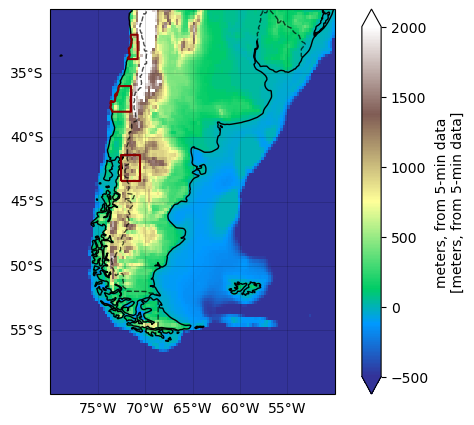

In [9]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (7,5), dpi = 100, subplot_kw = {"projection" : mapproj})
elev_kwargs = {"cmap" : "terrain",
               "vmin" : -500, 
               "vmax" : 2000}    # aim to keep 1:4 ratio to change from blue to green at zero
elev.plot(ax = ax, **elev_kwargs)

ax.gridlines(crs = mapproj, linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)

sf_chile2024.boundary.plot(ax = ax, color = "darkred", alpha = 1)
sf_chile2026.boundary.plot(ax = ax, color = "darkred", alpha = 1)
sf_patagonia.boundary.plot(ax = ax, color = "darkred", alpha = 1)

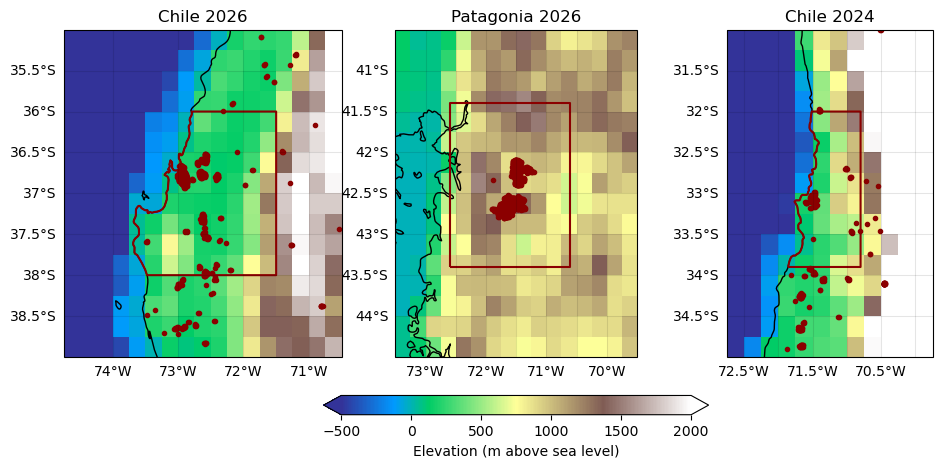

In [10]:
nc = 3
b = 1

fig, axs = plt.subplots(ncols = nc, nrows = 1, figsize = (nc*4, 5), dpi = 100, subplot_kw = {"projection" : mapproj})
plt.subplots_adjust(wspace = 0.035)
elev_kwargs = {"cmap" : "terrain",
               "vmin" : -500, 
               "vmax" : 2000}    # aim to keep 1:4 ratio to change from blue to green at zero

for i in range(nc):
    ax = axs[i]
    sf = [sf_chile2026, sf_patagonia, sf_chile2024][i]

    xn,yn,xx,yx = sf.bounds.values[0]
    cbar = elev.sel(lon = slice(xn-b,xx+b), lat = slice(yn-b,yx+b)).plot(ax = ax, **elev_kwargs, add_colorbar = False)
    sf.boundary.plot(ax = ax, color = "darkred")
    ax.coastlines()
    ax.set_title(["Chile 2026", "Patagonia 2026", "Chile 2024"][i])
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["left", "bottom"])

    if i < 2:
        px_2026.clip((xn-b,yn-b,xx+b,yx+b)).plot(ax = ax, color = "darkred", marker = ".")
    else:
        px_2024.clip((xn-b,yn-b,xx+b,yx+b)).plot(ax = ax, color = "darkred", marker = ".")

plt.colorbar(cbar, ax = axs, location = "bottom", label = "Elevation (m above sea level)", fraction = 0.05, pad = 0.1, extend = "both")
plt.savefig("fig/expl_elev_initial-regions.png")

# Koppen-Geiger climatology


In [11]:
kg = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/koppen-geiger/kg_classifications.nc").kg_cat.sel(lon = slice(Xn,Xx), lat = slice(Yn,Yx))

# group individual classes into broader categories
kg_grouped = xr.apply_ufunc(np.digitize, kg, kwargs={'bins': [0.5,3.5,7.5,16.5,28.5,30]})

Text(0.5, 1.0, 'Koppen-Geiger climatology')

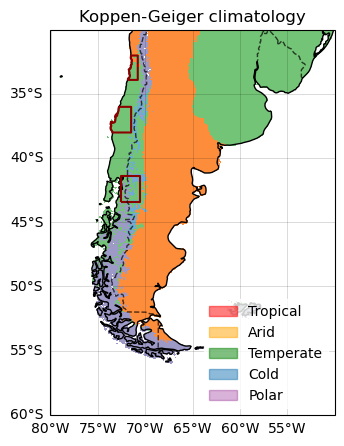

In [12]:
fig, ax = plt.subplots(ncols = 1, figsize = (7,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
kg_grouped.where(kg_grouped == 1).plot(ax = ax, cmap = "Reds", add_colorbar = False)      # tropical
kg_grouped.where(kg_grouped == 2).plot(ax = ax, cmap = "Oranges", add_colorbar = False)   # arid
kg_grouped.where(kg_grouped == 3).plot(ax = ax, cmap = "Greens", add_colorbar = False)    # temperate
kg_grouped.where(kg_grouped == 4).plot(ax = ax, cmap = "Blues", add_colorbar = False)     # cold
kg_grouped.where(kg_grouped == 5).plot(ax = ax, cmap = "Purples", add_colorbar = False)   # polar

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)

# add area of interest
sf_chile2024.boundary.plot(ax = ax, color = "darkred", alpha = 1)
sf_chile2026.boundary.plot(ax = ax, color = "darkred", alpha = 1)
sf_patagonia.boundary.plot(ax = ax, color = "darkred", alpha = 1)

plt.legend(handles = [matplotlib.patches.Patch(color = "red", label = "Tropical", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "orange", label = "Arid", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "green", label = "Temperate", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "tab:blue", label = "Cold", alpha = 0.5),
                      matplotlib.patches.Patch(color = "purple", label = "Polar", alpha = 0.3)], 
           edgecolor = "w", loc = "lower right")

plt.title("Koppen-Geiger climatology")

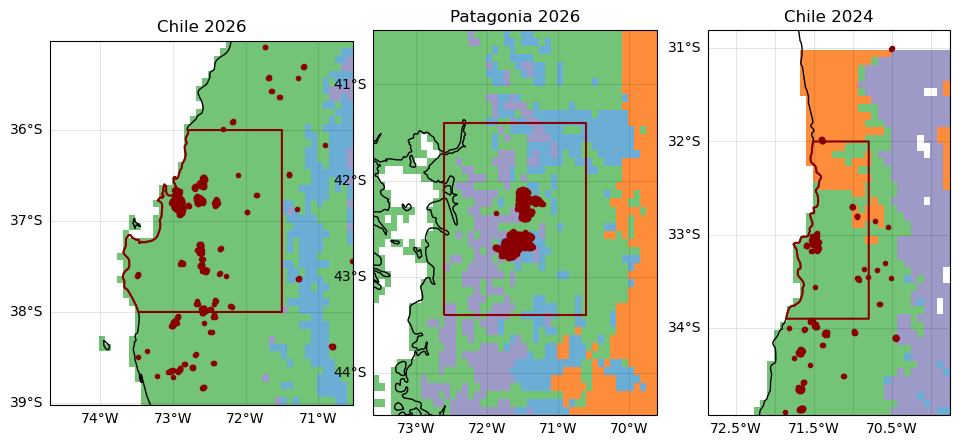

In [13]:
nc = 3
b = 1

fig, axs = plt.subplots(ncols = nc, nrows = 1, figsize = (nc*4, 5), dpi = 100, subplot_kw = {"projection" : mapproj})
plt.subplots_adjust(wspace = 0.035)

for i in range(nc):
    ax = axs[i]
    sf = [sf_chile2026, sf_patagonia, sf_chile2024][i]

    xn,yn,xx,yx = sf.bounds.values[0]
    da = kg_grouped.sel(lon = slice(xn-b,xx+b), lat = slice(yn-b,yx+b))

    da.where(da == 1).plot(ax = ax, cmap = "Reds", add_colorbar = False)      # tropical
    da.where(da == 2).plot(ax = ax, cmap = "Oranges", add_colorbar = False)   # arid
    da.where(da == 3).plot(ax = ax, cmap = "Greens", add_colorbar = False)    # temperate
    da.where(da == 4).plot(ax = ax, cmap = "Blues", add_colorbar = False)     # cold
    da.where(da == 5).plot(ax = ax, cmap = "Purples", add_colorbar = False)   # polar

    sf.boundary.plot(ax = ax, color = "darkred")
    ax.coastlines()
    ax.set_title(["Chile 2026", "Patagonia 2026", "Chile 2024"][i])
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["left", "bottom"])

    if i < 2:
        px_2026.clip((xn-b,yn-b,xx+b,yx+b)).plot(ax = ax, color = "darkred", marker = ".")
    else:
        px_2024.clip((xn-b,yn-b,xx+b,yx+b)).plot(ax = ax, color = "darkred", marker = ".")

plt.savefig("fig/expl_koppen-geiger_initial-regions.png")

# Check ERA5land data quality

In [14]:
fl = sorted(glob.glob("data/*1950-2026.nc"))

In [15]:
varlist = sorted(list(set([fnm.split("/")[-1].split("_")[0] for fnm in fl])))

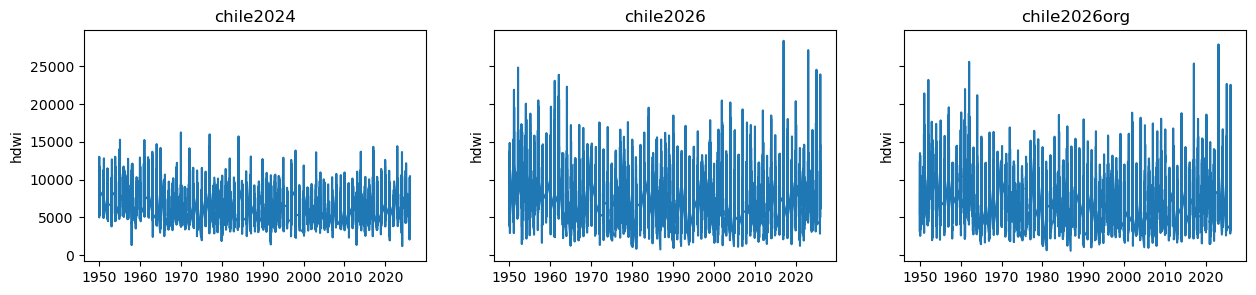

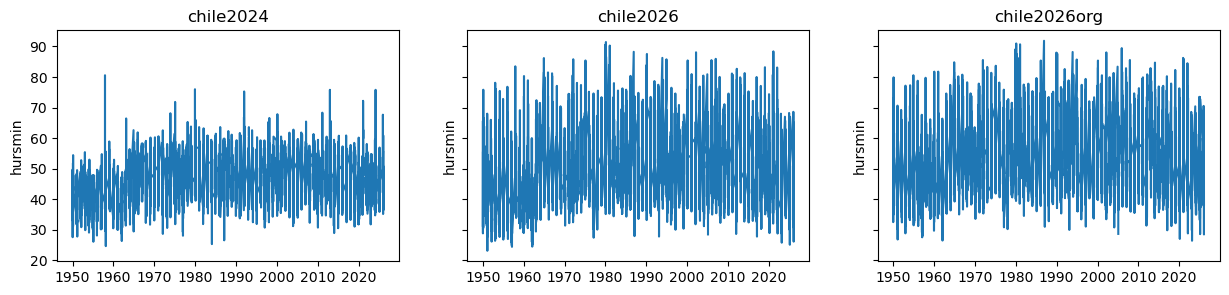

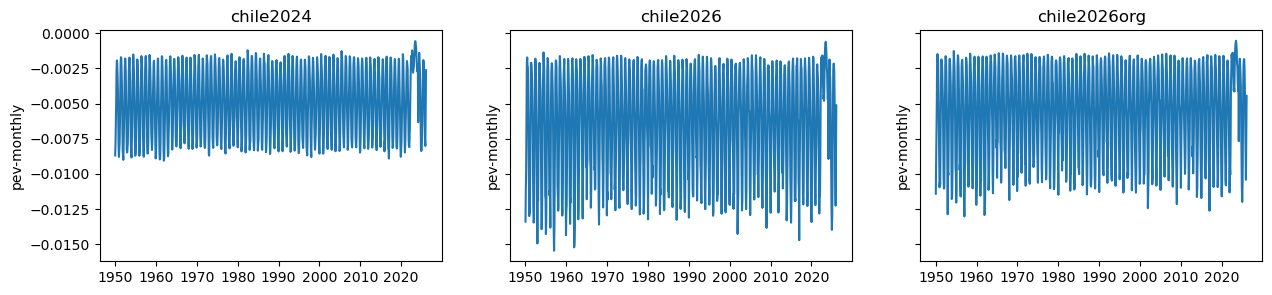

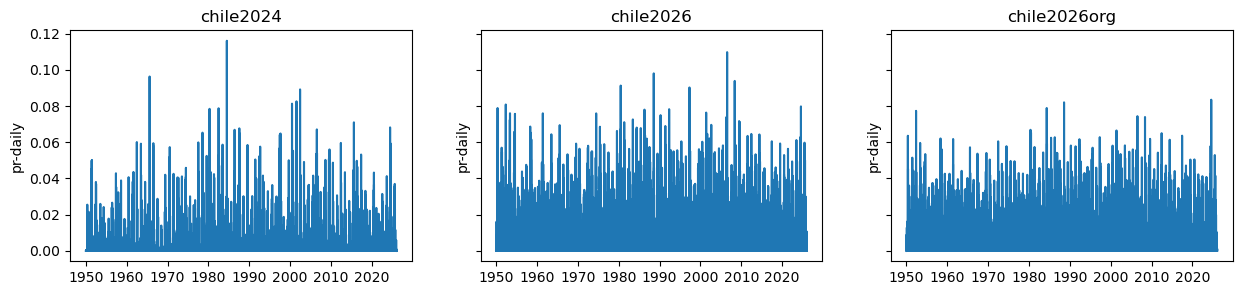

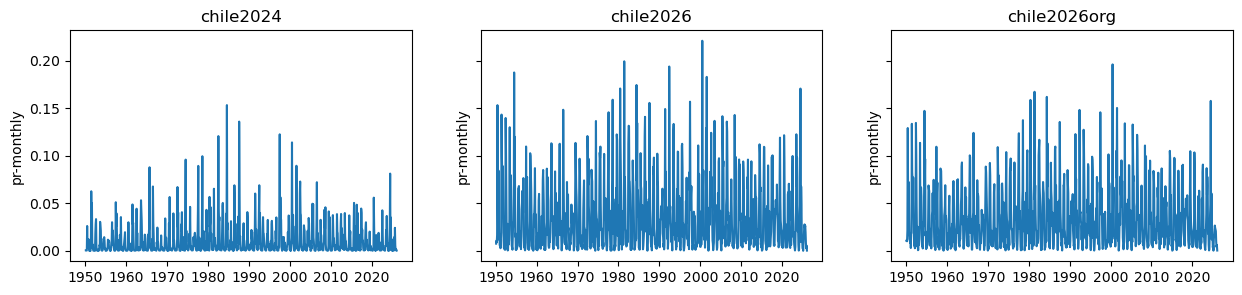

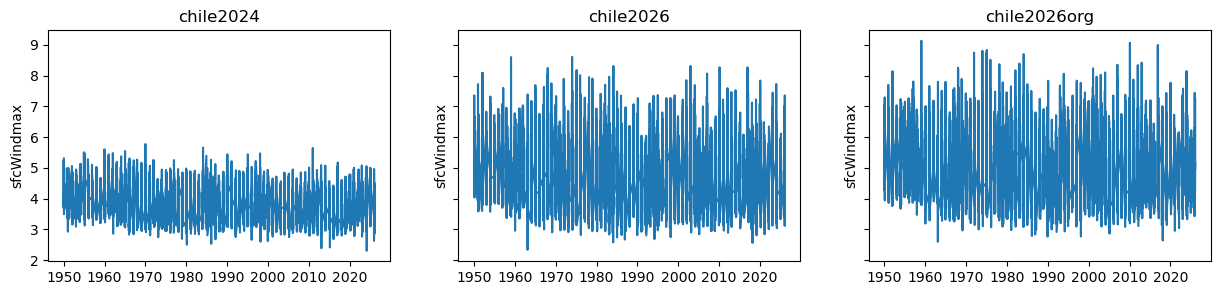

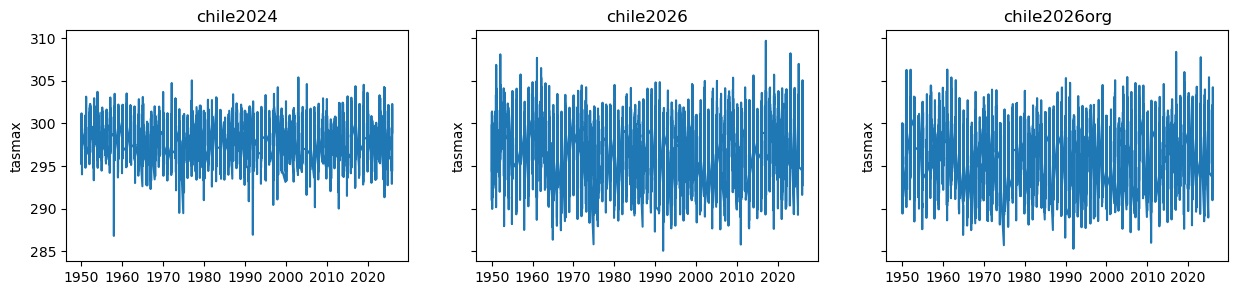

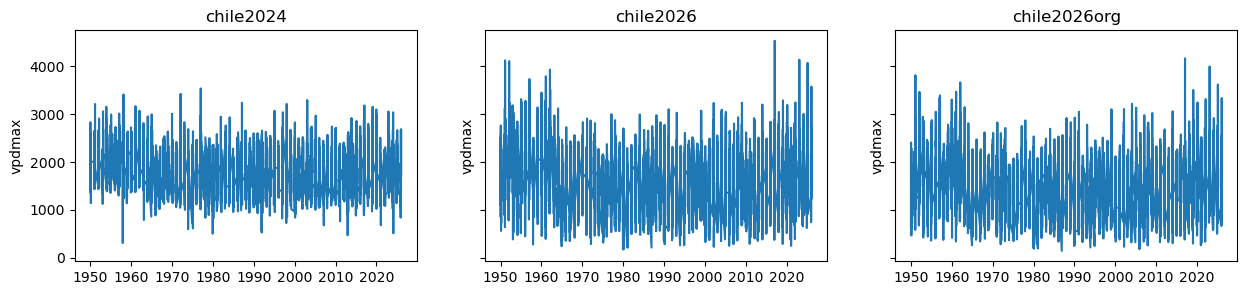

In [16]:
for vnm in varlist:
    vl = [fnm for fnm in fl if vnm in fnm]
    fig, axs = plt.subplots(ncols = 3, figsize = (3*5,3), dpi = 100, sharex = True, sharey = True)
    for i in range(3):
        ax = axs[i]
        fnm = vl[i]
        ts = xr.open_dataset(fnm)
        ts = ts[list(ts.data_vars)[0]]
        ts.plot(ax = ax)
        ax.set_title(fnm.split("_")[2])
        ax.set_xlabel("")
        ax.set_ylabel(vnm)
    plt.savefig("fig/check-data_"+vnm+".png")

# Quick plot of this year

In [17]:
rnm = "patagonia"
fl = sorted(glob.glob("data/*"+rnm+"*.nc"))

fl = [fnm for fnm in fl if not "pev" in fnm] # pre-cal PEV is definitely wrong

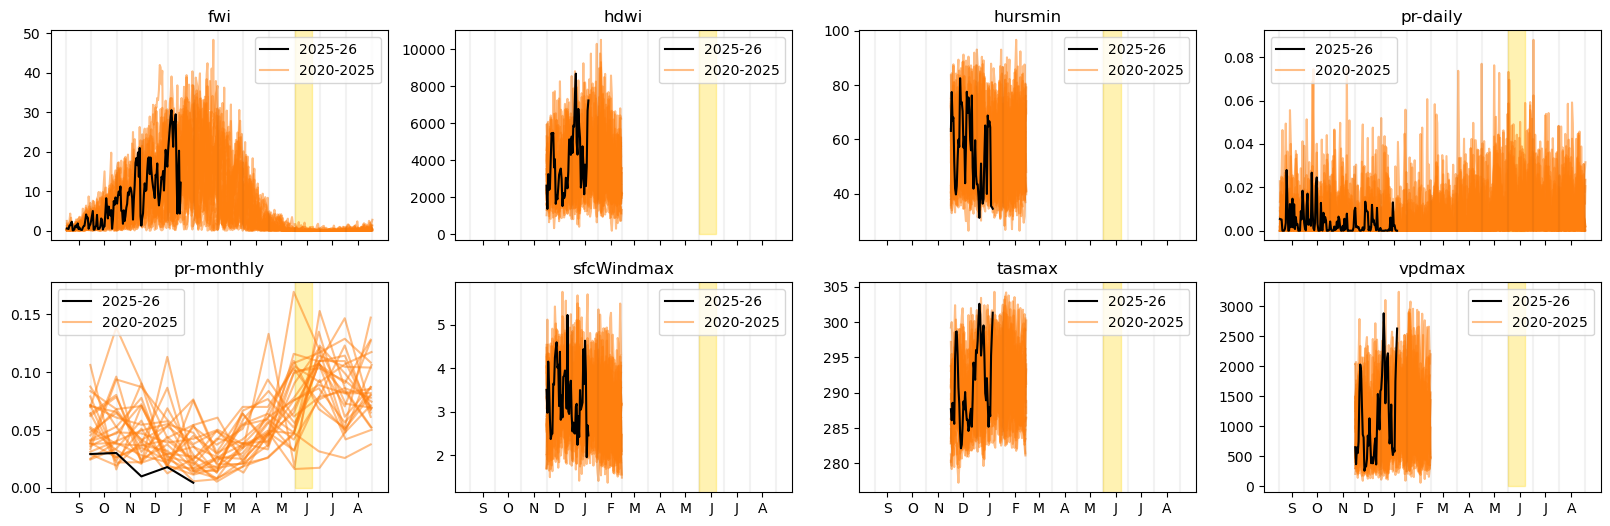

In [18]:
nc = 4; nr = int(np.ceil(len(fl)/nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*3), dpi = 100, sharex = True)

days = pd.date_range(start = "2025-09-01", end = "2026-10-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

for i in range(len(fl)):
    ax = axs.flatten()[i]
    fnm = fl[i]
    da = xr.open_dataset(fnm).dropna(dim = "time")
    vnm = list(da.data_vars)[0]
    da = da[vnm]

    ts = da.assign_coords(offset_time = ("time", [pd.Timestamp(t) + relativedelta(days = 121) for t in da.time.values])) # shift time for offset axes

    y = 2026; ts_y = ts.sel(time = ts.offset_time.dt.year == y)
    ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
    
    for y in range(2000,2026):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")

    ax.legend(["2025-26", "2020-2025"])
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    ax.set_title(fnm.split("/")[-1].split("_")[0])

    ylim = ax.get_ylim()
    if rnm == "chile2026":
        ax.add_patch(Rectangle((days.get_loc("2026-01-18"), 0), 3, ylim[1]+10, color = "gold", alpha = 0.3))
    elif rnm == "patagonia":
        ax.add_patch(Rectangle((days.get_loc("2026-06-01"), 0), 21, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)
    

for i in range(len(fl), nc*nr): axs.flatten()[i].set_axis_off()

plt.savefig("fig/expl_sub-indices_"+rnm+".png")

## Accumulated HDWI

In [29]:
rnm = "patagonia"

hdwi = xr.open_dataset("data/hdwi_era5land_"+rnm+"_1950-2026.nc").hdwi
hdwi = hdwi.assign_coords(offset_time = ("time", [pd.Timestamp(t) + relativedelta(days = 61) for t in hdwi.time.values])) # shift time for offset axes

days = pd.date_range(start = "2025-12-01", end = "2026-03-01")
labelticks = [i+31 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

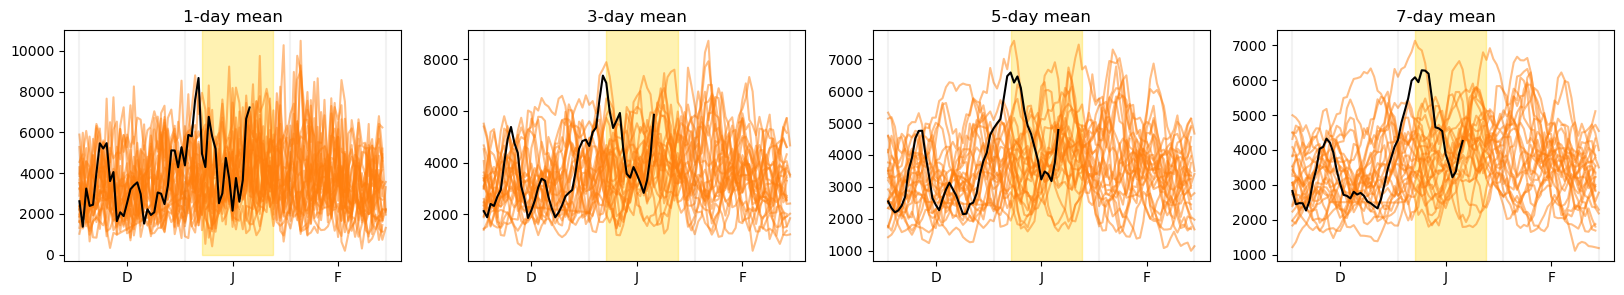

In [30]:
ndays = [1,3,5,7]

nc = 4; nr = int(np.ceil(len(ndays)/nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*3), dpi = 100, sharex = True)

for i in range(len(ndays)):
    ax = axs.flatten()[i]
    nd = ndays[i]

    ts = hdwi.rolling(time = nd).mean()

    y = 2026; ts_y = ts.sel(time = ts.offset_time.dt.year == y)
    ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
    
    for y in range(2000,2026):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")

    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x+31, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    ax.set_title(str(nd)+"-day mean")

    ylim = ax.get_ylim()
    if rnm == "chile2026":
        ax.add_patch(Rectangle((days.get_loc("2026-02-18"), 0), 3, ylim[1]+10, color = "gold", alpha = 0.3))
    elif rnm == "patagonia":
        ax.add_patch(Rectangle((days.get_loc("2026-02-06"), 0), 21, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)

plt.savefig("fig/expl_accumulated-hdwi_"+rnm+"_.png")

## Accumulated precip

In [6]:
rnm = "patagonia"

doy_offset = 131
pr = xr.open_dataset("data/pr-daily_era5land_"+rnm+"_1950-2026.nc").var228 * 1000
# pr.rolling(time = 91).sum().dropna("time").to_netcdf("pr-91day_"+rnm+"_era5land.nc")   # data for Tom
pr = pr.assign_coords(offset_time = ("time", [pd.Timestamp(t) + relativedelta(days = doy_offset) for t in pr.time.values])) # shift time for offset axes

days = pd.date_range(start = "2025-09-01", end = "2026-10-01")
# days = [d - relativedelta(days = doy_offset) for d in pd.date_range(start = "2026-01-01", end = "2027-01-01")]
labelticks = [i for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

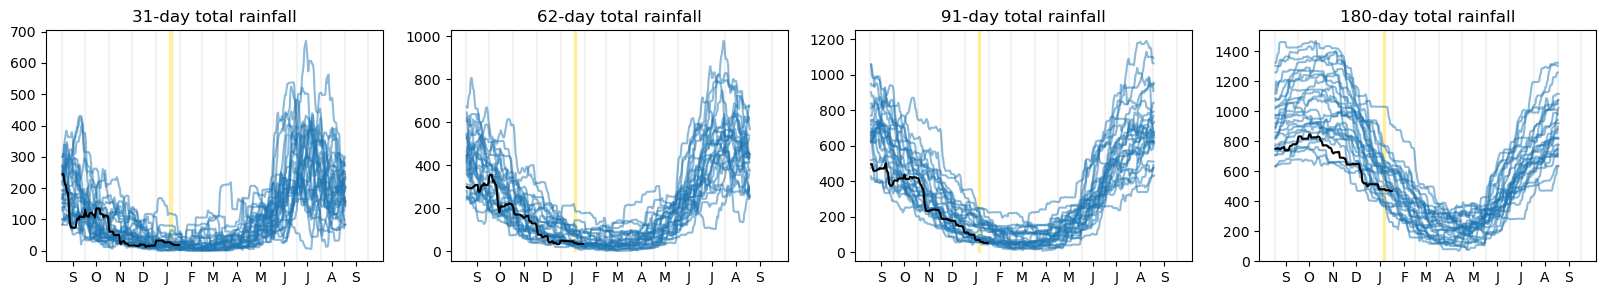

In [5]:
ndays = [31,62,91,180]

nc = 4; nr = int(np.ceil(len(ndays)/nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*3), dpi = 100, sharex = True)

for i in range(len(ndays)):
    ax = axs.flatten()[i]
    nd = ndays[i]

    ts = pr.rolling(time = nd).sum()

    y = 2026; ts_y = ts.sel(time = ts.offset_time.dt.year == y)
    ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
    
    for y in range(2000,2026):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")

    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    ax.set_title(str(nd)+"-day total rainfall")

    ylim = ax.get_ylim()
    if rnm == "chile2026":
        ax.add_patch(Rectangle((days.get_loc("2026-01-18"), 0), 3, ylim[1]+10, color = "gold", alpha = 0.3))
    elif rnm == "patagonia":
        ax.add_patch(Rectangle((days.get_loc("2026-01-06"), 0), 21, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)

plt.savefig("fig/expl_accumulated-pr_"+rnm+"_.png")

## Check timing of HDWI annual maxima

In [59]:
hdwi_ar = xr.open_dataset("data/hdwi_era5land_patagonia_1950-2026.nc").hdwi

In [ ]:
hdwi5 = hdwi_ar.rolling(time = 5).mean() / 1000

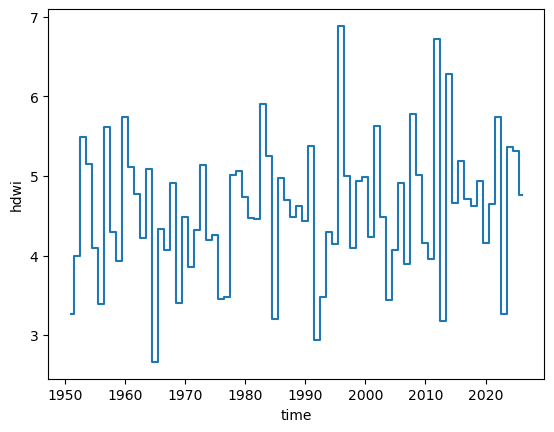

In [70]:
hdwi5.resample(time = "QE-DEC").max().groupby("time.season")["DJF"].plot(drawstyle = "steps-mid")

In [61]:
mmax = xr.concat([hdwi5.sel(time = str(y)).idxmax() for y in range(1950,2027)], "time")

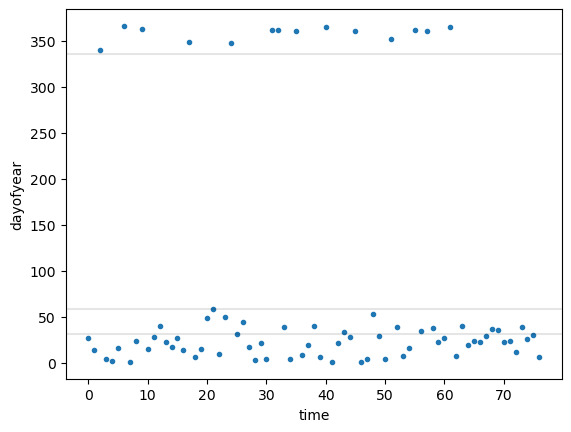

In [65]:
mmax.dt.dayofyear.plot(ls = "", marker = ".")
[plt.axhline(y, color = "k", alpha = 0.1) for y in [31,59,366-31]]

# ENSO & Southern Annular Mode

In [96]:
sam = xr.open_dataset("data/sam-monthly_era5.nc").sam.rename("sam_era5")
sam_cpc = xr.open_dataset("data/sam-monthly_cpc.nc").SAM.rename("sam_cpc", TSAXIS = "time").resample(time = "MS").mean()

nino34 = xr.open_dataset("data/nino34det-monthly_ersst.nc").nino34.dropna("time")

pr_chile = xr.open_dataset("data/pr-daily_era5land_chile2026_1950-2026.nc").var228.resample(time = "MS").mean().rename("pr_chile")
pr_patagonia = xr.open_dataset("data/pr-daily_era5land_patagonia_1950-2026.nc").var228.resample(time = "MS").mean().rename("pr_patagonia")

tmax_chile = xr.open_dataset("data/tasmax_era5land_chile2026_1950-2026.nc").tasmax.resample(time = "MS").mean().rename("tx_chile")
tmax_patagonia = xr.open_dataset("data/tasmax_era5land_patagonia_1950-2026.nc").tasmax.resample(time = "MS").mean().rename("tx_patagonia")

In [97]:
df = merge_byindex([da.to_dataframe() for da in [sam, sam_cpc, nino34, pr_chile, pr_patagonia, tmax_chile, tmax_patagonia]]).dropna(axis = 0, how = "any")

In [98]:
df.corr()

,sam_era5,sam_cpc,nino34,pr_chile,pr_patagonia,tx_chile,tx_patagonia
sam_era5,1.000000,0.876688,-0.195899,-0.252704,-0.318576,0.267158,0.347053
sam_cpc,0.876688,1.000000,-0.287923,-0.234483,-0.300017,0.230657,0.336719
nino34,-0.195899,-0.287923,1.000000,0.005918,-0.001256,-0.148620,-0.118908
pr_chile,-0.252704,-0.234483,0.005918,1.000000,0.650274,-0.588173,-0.418872
pr_patagonia,-0.318576,-0.300017,-0.001256,0.650274,1.000000,-0.667335,-0.703234
tx_chile,0.267158,0.230657,-0.148620,-0.588173,-0.667335,1.000000,0.837424
tx_patagonia,0.347053,0.336719,-0.118908,-0.418872,-0.703234,0.837424,1.000000


# Event definition figures

## HDWI maps

In [183]:
px = pd.read_csv("data/modis_conf-80.csv", index_col = "acq_date", parse_dates = ["acq_date"])
px = gpd.GeoDataFrame(px, geometry = gpd.points_from_xy(x=px.longitude, y=px.latitude), crs = "EPSG:4326").loc["2026"]

In [184]:
px_chile = px.clip((-75, -34, -70, -40)).sort_index()
px_patagonia = px.clip((-75, -45, -70, -40)).sort_index()

In [185]:
hdwi = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/sam-fires/obs/hdwi_era5land_sam_1950-2026.nc").hdwi.reset_coords(drop = True).sel(time = slice("2025-07", "2026")) / 1000
ts_chile = xr.open_dataset("data/hdwi_era5land_chile2026_1950-2026.nc").hdwi
ts_patagonia = xr.open_dataset("data/hdwi_era5land_patagonia_1950-2026.nc").hdwi

In [186]:
chile_enddate = ts_chile.rolling(time = 2).mean().sel(time = slice("2025-07",None)).idxmax()
patagonia_enddate = ts_patagonia.rolling(time = 5).mean().sel(time = slice("2025-07",None)).idxmax()

In [187]:
hdwi_chile = hdwi.rolling(time = 2).mean().sel(time = chile_enddate)
hdwi_patagonia = hdwi.rolling(time = 5).mean().sel(time = patagonia_enddate)

/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


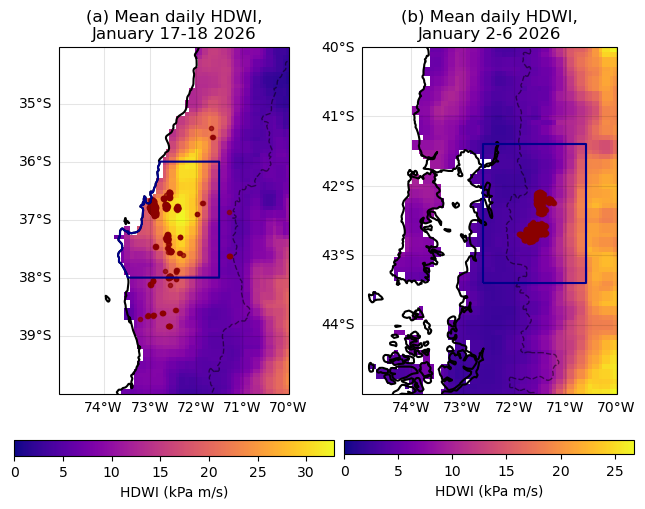

In [171]:
nc = 2

fig, axs = plt.subplots(ncols = nc, nrows = 1, figsize = (nc*4, 6), dpi = 100, subplot_kw = {"projection" : mapproj}, gridspec_kw = {"width_ratios" : [1.1,1]})
plt.subplots_adjust(wspace = 0.035)

cbar_kwargs = {"location" : "bottom", "label" : "HDWI (kPa m/s)", "pad" : 0.1}

ax = axs[0]
hdwi_chile.sel(longitude = slice(-75, -70), latitude = slice(-34,-40)).plot(ax = ax, cmap = "plasma", vmin = 0, cbar_kwargs = cbar_kwargs)                                                 
sf_chile2026.boundary.plot(ax = ax, color = "darkblue")
ax.set_title("(a) Mean daily HDWI,\nJanuary 17-18 2026")
px_chile.loc[slice("2026-01-17", "2026-01-19")].plot(ax = ax, marker = ".", color = "darkred", alpha = 0.7)

ax = axs[1]
hdwi_patagonia.sel(longitude = slice(-75, -70), latitude = slice(-40,-45)).plot(ax = ax, cmap = "plasma", vmin = 0, cbar_kwargs = cbar_kwargs)                                                 
sf_patagonia.boundary.plot(ax = ax, color = "darkblue")
ax.set_title("(b) Mean daily HDWI,\nJanuary 2-6 2026")
px_patagonia.loc[slice("2026-01-06", "2026-01-31")].plot(ax = ax, marker = ".", color = "darkred", alpha = 0.7)

for ax in axs:
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["left", "bottom"])
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.coastlines(lw = 1.5)

plt.savefig("fig/event-maps_hdwi.png")

In [172]:
# anomaly wrt DJF mean

In [173]:
hdwi_clim = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/sam-fires/obs/hdwi_era5land_sam_1950-2026.nc").hdwi.reset_coords(drop = True).sel(time = slice("1990-12","2020-02"))
hdwi_djf = hdwi_clim.resample(time = "QS-DEC").mean().groupby("time.season")["DJF"].mean("time") / 1000

anom_chile = hdwi_chile - hdwi_djf
anom_patagonia = hdwi_patagonia - hdwi_djf

relanom_chile = anom_chile / hdwi_djf * 100
relanom_patagonia = anom_patagonia / hdwi_djf * 100

/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


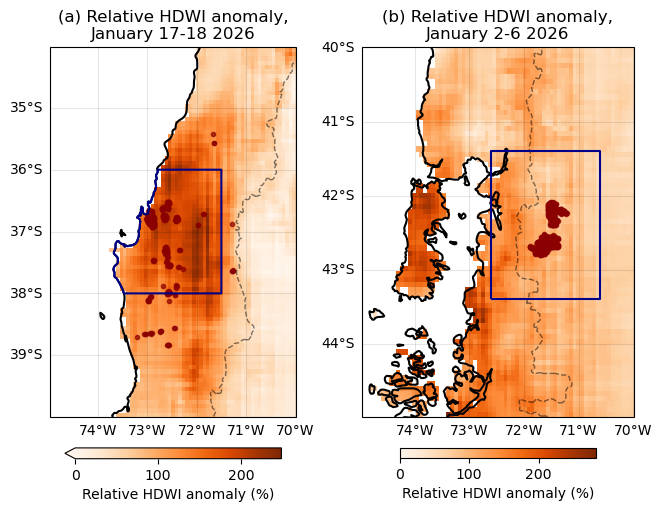

In [174]:
nc = 2

fig, axs = plt.subplots(ncols = nc, nrows = 1, figsize = (nc*4, 8), dpi = 100, subplot_kw = {"projection" : mapproj}, gridspec_kw = {"width_ratios" : [1.1,1]})
plt.subplots_adjust(wspace = 0.1)

plot_kwargs = {"vmin" : 0, "cmap" : "Oranges"}
cbar_kwargs = {"location" : "bottom", "label" : "Relative HDWI anomaly (%)", "pad" : 0.05, "shrink" : 0.7, "fraction" : 0.35}

ax = axs[0]
relanom_chile.sel(longitude = slice(-75, -70), latitude = slice(-34,-40)).plot(ax = ax, **plot_kwargs, cbar_kwargs = cbar_kwargs)
sf_chile2026.boundary.plot(ax = ax, color = "darkblue")
ax.set_title("(a) Relative HDWI anomaly,\nJanuary 17-18 2026")
px_chile.loc[slice("2026-01-17", "2026-01-19")].plot(ax = ax, marker = ".", color = "darkred", alpha = 0.7)

ax = axs[1]
relanom_patagonia.sel(longitude = slice(-75, -70), latitude = slice(-40,-45)).plot(ax = ax, **plot_kwargs, cbar_kwargs = cbar_kwargs)                                                 
sf_patagonia.boundary.plot(ax = ax, color = "darkblue")
ax.set_title("(b) Relative HDWI anomaly,\nJanuary 2-6 2026")
px_patagonia.loc[slice("2026-01-06", "2026-01-31")].plot(ax = ax, marker = ".", color = "darkred", alpha = 0.7)

for ax in axs:
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["left", "bottom"])
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.coastlines(lw = 1.5)

plt.savefig("fig/event-maps_hdwi-relanomaly.png")

### Panel figure

In [188]:
px = pd.read_csv("data/modis_conf-80.csv", index_col = "acq_date", parse_dates = ["acq_date"])
px = gpd.GeoDataFrame(px, geometry = gpd.points_from_xy(x=px.longitude, y=px.latitude), crs = "EPSG:4326").loc["2026"]

px_chile = px.clip((-75, -34, -70, -40)).sort_index()
px_patagonia = px.clip((-75, -45, -70, -40)).sort_index()

hdwi = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/sam-fires/obs/hdwi_era5land_sam_1950-2026.nc").hdwi.reset_coords(drop = True).sel(time = slice("2025-07", "2026")) / 1000
ts_chile = xr.open_dataset("data/hdwi_era5land_chile2026_1950-2026.nc").hdwi
ts_patagonia = xr.open_dataset("data/hdwi_era5land_patagonia_1950-2026.nc").hdwi

chile_enddate = ts_chile.rolling(time = 2).mean().sel(time = slice("2025-07",None)).idxmax()
patagonia_enddate = ts_patagonia.rolling(time = 5).mean().sel(time = slice("2025-07",None)).idxmax()

hdwi_chile = hdwi.rolling(time = 2).mean().sel(time = chile_enddate)
hdwi_patagonia = hdwi.rolling(time = 5).mean().sel(time = patagonia_enddate)

hdwi_clim = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/sam-fires/obs/hdwi_era5land_sam_1950-2026.nc").hdwi.reset_coords(drop = True).sel(time = slice("1990-12","2020-02"))
hdwi_djf = hdwi_clim.resample(time = "QS-DEC").mean().groupby("time.season")["DJF"].mean("time") / 1000

anom_chile = hdwi_chile - hdwi_djf
anom_patagonia = hdwi_patagonia - hdwi_djf

relanom_chile = anom_chile / hdwi_djf * 100
relanom_patagonia = anom_patagonia / hdwi_djf * 100

In [189]:
# axis labels for HDWI
days = pd.date_range(start = "2025-12-01", end = "2026-03-01")
labelticks = [i+31 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


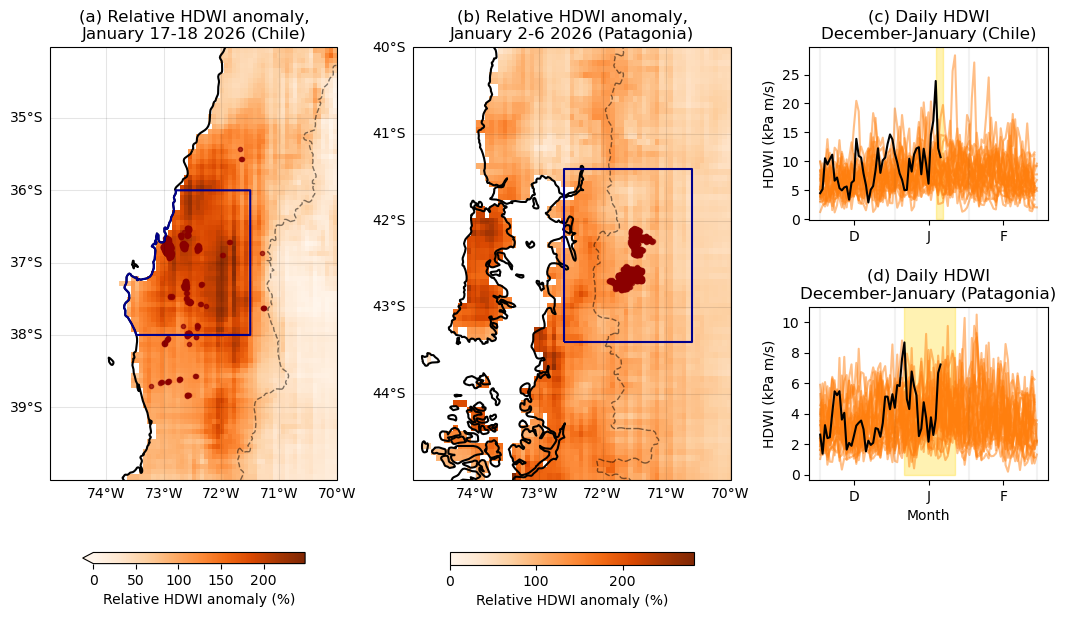

In [190]:
nc = 3; nr = 2
fig = plt.figure(layout = "constrained", figsize = (nc*3.5,nr*3), dpi = 100)
gs = gridspec.GridSpec(ncols = 3, nrows = 2, figure = fig, width_ratios = [1,1.1,0.75])

plot_kwargs = {"vmin" : 0, "cmap" : "Oranges"}
cbar_kwargs = {"location" : "bottom", "label" : "Relative HDWI anomaly (%)", "pad" : 0.05, "shrink" : 0.7, "fraction" : 0.35}

# HDWI map
for i in range(2):
    
    ra = [relanom_chile.sel(longitude = slice(-75, -70), latitude = slice(-34,-40)),
          relanom_patagonia.sel(longitude = slice(-75, -70), latitude = slice(-40,-45))][i]
    sf = [sf_chile2026, sf_patagonia][i]
    fpx = [px_chile.loc[slice("2026-01-17", "2026-01-19")],
           px_patagonia.loc[slice("2026-01-06", "2026-01-31")]][i]
    title = ["(a) Relative HDWI anomaly,\nJanuary 17-18 2026 (Chile)",
             "(b) Relative HDWI anomaly,\nJanuary 2-6 2026 (Patagonia)"][i]
    
    ax = fig.add_subplot(gs[:, i], projection = mapproj)
    ra.plot(ax = ax, **plot_kwargs, cbar_kwargs = cbar_kwargs)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["left", "bottom"])
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.coastlines(lw = 1.5)
    sf.boundary.plot(ax = ax, color = "darkblue")
    fpx.plot(ax = ax, marker = ".", color = "darkred", alpha = 0.7)
    ax.set_title(title)

    
# time series
for i in range(2):
    ax = fig.add_subplot(gs[i, 2])
    ts = [ts_chile, ts_patagonia][i]
    ts = ts.assign_coords(offset_time = ("time", [pd.Timestamp(t) + relativedelta(days = 61) for t in ts.time.values])) / 1000
    
    y = 2026; ts_y = ts.sel(time = ts.offset_time.dt.year == y)
    ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
    
    for y in range(2000,2026):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x+31, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    ax.set_ylabel("HDWI (kPa m/s)")
    
    ax.set_title(["(c) Daily HDWI\nDecember-January (Chile)", "(d) Daily HDWI\nDecember-January (Patagonia)"][i])

    ylim = ax.get_ylim()
    if i == 0:
        ax.add_patch(Rectangle((days.get_loc("2026-02-18"), 0), 3, ylim[1]+10, color = "gold", alpha = 0.3))
    elif i == 1:
        ax.add_patch(Rectangle((days.get_loc("2026-02-05"), 0), 21, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)

ax.set_xlabel("Month")

plt.savefig("fig/event-def_hdwi_map+ts.png")

## Precip deficit maps

In [176]:
# ! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-1/2026-02-07/a8341c36a988bdf5274815d73bcae225.nc -O data/pr-monthly.nc
pr = (xr.open_dataset("data/pr-monthly.nc").tp * 1000).reset_coords(drop = True)

pr_ndj = pr.sel(valid_time = pr.valid_time.dt.month.isin([11,12,1])).resample(valid_time = "YE-JUL").sum()   # seasonal accumulated precip
pr_ndj = pr_ndj.where(pr_ndj > 0)

In [177]:
pr_2026 = pr_ndj.sel(valid_time = "2026")
pr_clim = pr_ndj.sel(valid_time = slice("1990","2020")).mean("valid_time")
pr_anom = pr_2026 - pr_clim
pr_relanom = pr_anom / pr_clim * 100

/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


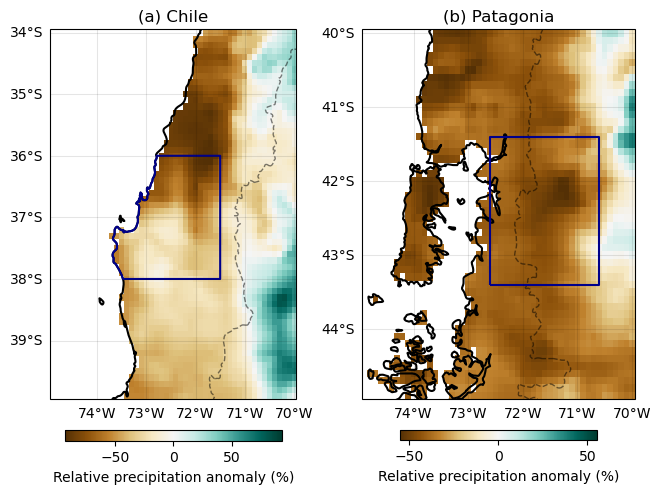

In [178]:
nc = 2

fig, axs = plt.subplots(ncols = nc, nrows = 1, figsize = (nc*4, 8), dpi = 100, subplot_kw = {"projection" : mapproj}, gridspec_kw = {"width_ratios" : [1.1,1]})
plt.subplots_adjust(wspace = 0.1)

plot_kwargs = {"cmap" : "BrBG"}
cbar_kwargs = {"location" : "bottom", "label" : "Relative precipitation anomaly (%)", "pad" : 0.05, "shrink" : 0.7, "fraction" : 0.35}

ax = axs[0]
pr_relanom.sel(longitude = slice(-75, -70), latitude = slice(-34,-40)).plot(ax = ax, **plot_kwargs, cbar_kwargs = cbar_kwargs)
sf_chile2026.boundary.plot(ax = ax, color = "darkblue")
ax.set_title("(a) Chile")
# px_chile.loc[slice("2026-01-17", "2026-01-19")].plot(ax = ax, marker = ".", color = "darkred", alpha = 0.7)

ax = axs[1]
pr_relanom.sel(longitude = slice(-75, -70), latitude = slice(-40,-45)).plot(ax = ax, **plot_kwargs, cbar_kwargs = cbar_kwargs)                                                 
sf_patagonia.boundary.plot(ax = ax, color = "darkblue")
ax.set_title("(b) Patagonia")
# px_patagonia.loc[slice("2026-01-06", "2026-01-31")].plot(ax = ax, marker = ".", color = "darkred", alpha = 0.7)

for ax in axs:
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["left", "bottom"])
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.coastlines(lw = 1.5)

plt.savefig("fig/event-maps_pr-ndj-relanomaly.png")

### Panel figure

In [179]:
ts_chile = xr.open_dataset("data/pr-daily_era5land_chile2026_1950-2026.nc").var228.rolling(time = 91).sum()
ts_patagonia = xr.open_dataset("data/pr-daily_era5land_patagonia_1950-2026.nc").var228.rolling(time = 91).sum()

/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


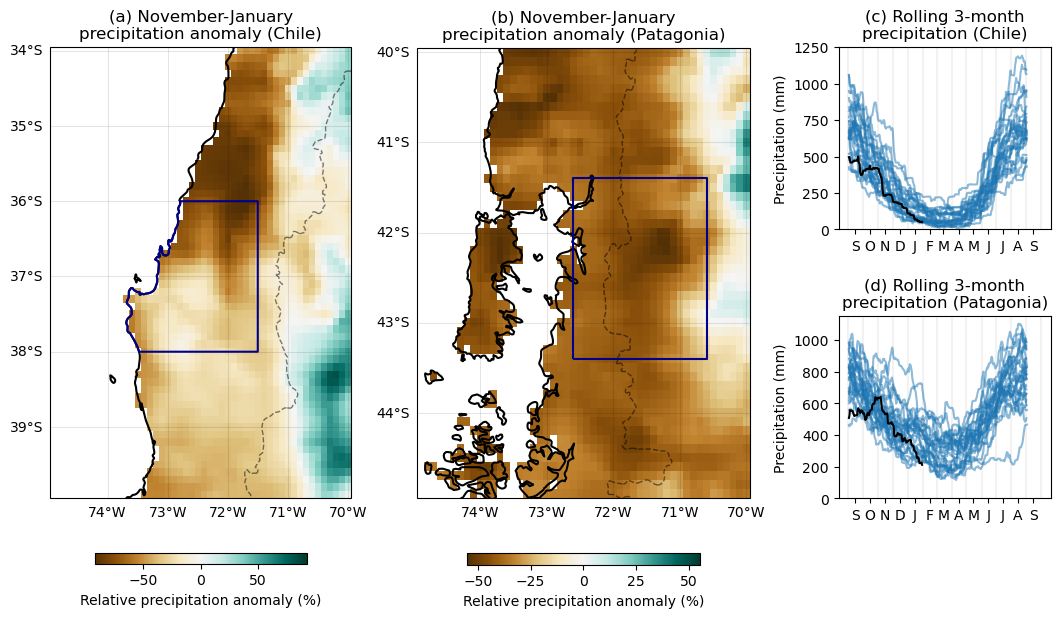

In [180]:
nc = 3; nr = 2
fig = plt.figure(layout = "constrained", figsize = (nc*3.5,nr*3), dpi = 100)
gs = gridspec.GridSpec(ncols = 3, nrows = 2, figure = fig, width_ratios = [1,1.1,0.7])

plot_kwargs = {"cmap" : "BrBG"}
cbar_kwargs = {"location" : "bottom", "label" : "Relative precipitation anomaly (%)", "pad" : 0.05, "shrink" : 0.7, "fraction" : 0.35}

days = pd.date_range(start = "2025-09-01", end = "2026-10-01")
# days = [d - relativedelta(days = doy_offset) for d in pd.date_range(start = "2026-01-01", end = "2027-01-01")]
labelticks = [i for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

# precip anomaly map
for i in range(2):
    
    ra = [pr_relanom.sel(longitude = slice(-75, -70), latitude = slice(-34,-40)),
          pr_relanom.sel(longitude = slice(-75, -70), latitude = slice(-40,-45))][i]
    sf = [sf_chile2026, sf_patagonia][i]
    title = ["(a) November-January\nprecipitation anomaly (Chile)",
             "(b) November-January\nprecipitation anomaly (Patagonia)"][i]
    
    ax = fig.add_subplot(gs[:, i], projection = mapproj)
    ra.plot(ax = ax, **plot_kwargs, cbar_kwargs = cbar_kwargs)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["left", "bottom"])
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.coastlines(lw = 1.5)
    sf.boundary.plot(ax = ax, color = "darkblue")
    ax.set_title(title)

    
# time series
for i in range(2):
    ax = fig.add_subplot(gs[i, 2])
    ts = [ts_chile, ts_patagonia][i]
    ts = ts.assign_coords(offset_time = ("time", [pd.Timestamp(t) + relativedelta(days = 131) for t in ts.time.values])) * 1000
    
    y = 2026; ts_y = ts.sel(time = ts.offset_time.dt.year == y)
    ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
    
    for y in range(2000,2026):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    ax.set_ylabel("Precipitation (mm)")
    
    ax.set_title(["(c) Rolling 3-month\nprecipitation (Chile)", "(d) Rolling 3-month\nprecipitation (Patagonia)"][i])

    # ylim = ax.get_ylim()
#     if i == 0:
#         ax.add_patch(Rectangle((days.get_loc("2026-02-18"), 0), 3, ylim[1]+10, color = "gold", alpha = 0.3))
#     elif i == 1:
#         ax.add_patch(Rectangle((days.get_loc("2026-02-05"), 0), 21, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(0,None)

# ax.set_xlabel("Month")

plt.savefig("fig/event-def_precip_map+ts.png")

## Double-check precip time series - something wrong in original ERA5land download?

In [32]:
ts_chile = pr_ndj.where(regionmask.mask_geopandas(sf_chile2026, pr) == 0, drop = True).mean(["latitude", "longitude"])
ts_patagonia = pr_ndj.where(regionmask.mask_geopandas(sf_patagonia, pr) == 0, drop = True).mean(["latitude", "longitude"])

In [33]:
tso_chile = xr.open_dataset("data/pr-monthly_era5land_chile2026_1950-2026.nc").tp * 1000
tso_chile = tso_chile.sel(time = tso_chile.time.dt.month.isin([11,12,1])).resample(time = "YE-JUL").mean()

tso_patagonia = xr.open_dataset("data/pr-monthly_era5land_patagonia_1950-2026.nc").tp * 1000
tso_patagonia = tso_patagonia.sel(time = tso_patagonia.time.dt.month.isin([11,12,1])).resample(time = "YE-JUL").mean()

In [ ]:
tso_chile.plot()
ts_chile.plot()

## Accumulated precip

In [46]:
hdwi_chile = xr.open_dataset("data/hdwi_era5land_chile2026_1950-2026.nc").hdwi / 1000
hdwi_patagonia = xr.open_dataset("data/hdwi_era5land_patagonia_1950-2026.nc").hdwi / 1000

pr_chile = xr.open_dataset("data/pr-daily_era5land_chile2026_1950-2026.nc").var228 * 1000
pr_patagonia = xr.open_dataset("data/pr-daily_era5land_patagonia_1950-2026.nc").var228 * 1000

In [61]:
chile_m = xr.open_dataset("data/pr-monthly_era5land_chile2026_1950-2026.nc").tp.rename(valid_time = "time") * 1000
patagonia_m = xr.open_dataset("data/pr-monthly_era5land_patagonia_1950-2026.nc").tp.rename(valid_time = "time") * 1000

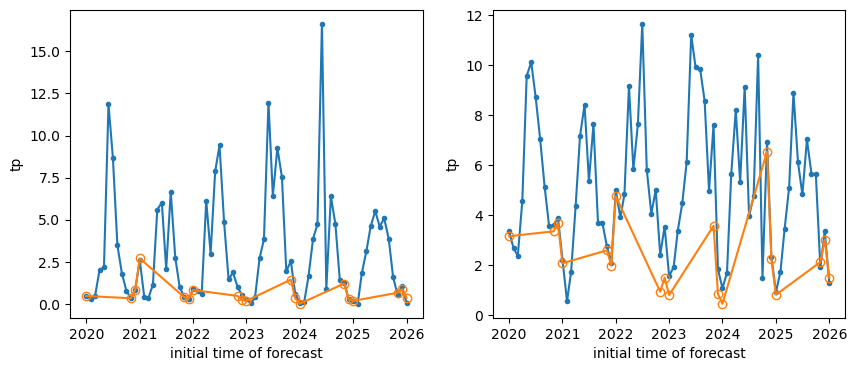

In [62]:
fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100)

ax = axs[0]
pr_chile.sel(time = slice("2020",None)).resample(time = "MS").mean().plot(ax = ax, marker = ".")
chile_m.sel(time = slice("2020",None)).plot(ax = ax, marker = "o", mfc = "none")

ax = axs[1]
pr_patagonia.sel(time = slice("2020",None)).resample(time = "MS").mean().plot(ax = ax, marker = ".")
patagonia_m.sel(time = slice("2020",None)).plot(ax = ax, marker = "o", mfc = "none")


In [ ]:
# nc = 2; nr = 1;
# fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*3), dpi = 100, sharex = True)

# for i in range(nc):
    

In [ ]:
rnm = "patagonia"

doy_offset = 131
pr = xr.open_dataset("data/pr-daily_era5land_"+rnm+"_1950-2026.nc").var228 * 1000
# pr.rolling(time = 91).sum().dropna("time").to_netcdf("pr-91day_"+rnm+"_era5land.nc")   # data for Tom
pr = pr.assign_coords(offset_time = ("time", [pd.Timestamp(t) + relativedelta(days = doy_offset) for t in pr.time.values])) # shift time for offset axes

days = pd.date_range(start = "2025-09-01", end = "2026-10-01")
# days = [d - relativedelta(days = doy_offset) for d in pd.date_range(start = "2026-01-01", end = "2027-01-01")]
labelticks = [i for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

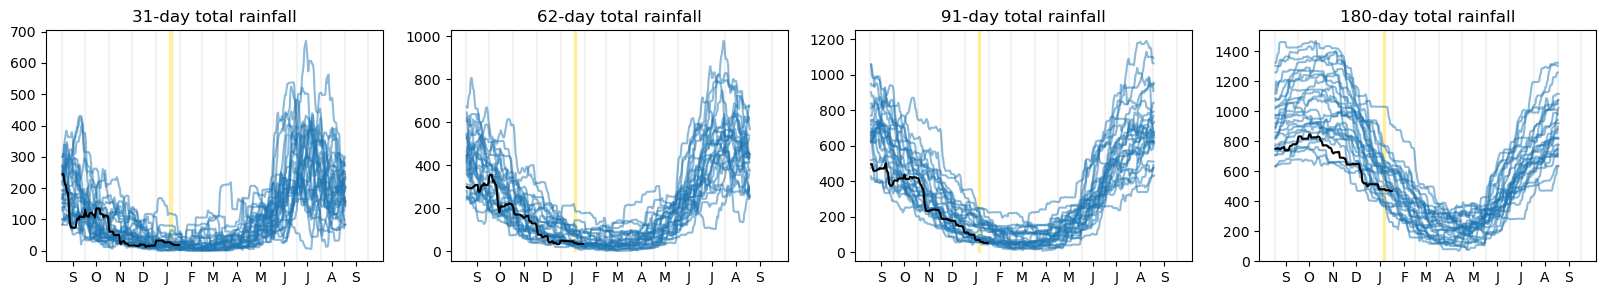

In [5]:
ndays = [31,62,91,180]

nc = 4; nr = int(np.ceil(len(ndays)/nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*3), dpi = 100, sharex = True)

for i in range(len(ndays)):
    ax = axs.flatten()[i]
    nd = ndays[i]

    ts = pr.rolling(time = nd).sum()

    y = 2026; ts_y = ts.sel(time = ts.offset_time.dt.year == y)
    ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
    
    for y in range(2000,2026):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")

    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    ax.set_title(str(nd)+"-day total rainfall")

    ylim = ax.get_ylim()
    if rnm == "chile2026":
        ax.add_patch(Rectangle((days.get_loc("2026-01-18"), 0), 3, ylim[1]+10, color = "gold", alpha = 0.3))
    elif rnm == "patagonia":
        ax.add_patch(Rectangle((days.get_loc("2026-01-06"), 0), 21, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)

plt.savefig("fig/expl_accumulated-pr_"+rnm+"_.png")